In [1]:
import sys
sys.path.append("..")
from vos_dataset import VOSDataset, get_loader
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from omegaconf import OmegaConf

In [8]:
config = {
    "description": "Positional embed before cross attention. No sparse embeddings. Pos embed wt has shape (256)",
    "precision": "32",
    "num_devices": 1,
    "num_epochs": 300,
    "save_log_weights_interval": 20,
    "metric_train_eval_interval": 20,
    "model_checkpoint_at": "checkpoints",
    "img_size": 1024,
    "out_dir": "/",
    "focal_wt": 20,
    "num_tokens": 1,
    "opt": {
        "learning_rate": 4e-4, #1e-4
        "auto_lr": False,
        "weight_decay": 1e-4,
        "decay_factor": 1/2,
        "steps": [100, 250],
    },
    "model": {
        "type": "vit_l",
        "checkpoint": "sam_vit_l_0b3195.pth",
        "requires_grad": {
            "image_encoder": False,
            "prompt_encoder": False,
            "mask_decoder": False,
            "propagation_module": True,
        },
    },
    "dataset": {
        "name": "moca",
        "root_dir": "../raw/",
        "train_split": 0.8, # Only for MoCA
        "stage1": True,
        "batch_size": 4,
        "max_num_obj": 3,
        "num_frames": 3,
        "max_jump": 5,
        "num_workers": 0,
        "pin_memory": False,
        "persistent_workers": False,
    },
}


# First use cpu to load models. Pytorch Lightning will automatically move it to GPUs.
cfg = OmegaConf.create(config).dataset

In [9]:
train, val = get_loader(cfg)

Training Samples:  56
56 out of 56 videos accepted in ../raw/MoCA-Mask/MoCA_Video/TrainDataset_per_sq.
Validation Samples:  15
15 out of 15 videos accepted in ../raw/MoCA-Mask/MoCA_Video/TrainDataset_per_sq.


In [137]:
x = val.dataset[2]

In [138]:
for i in x:
    try:
        print(i, x[i].shape, x[i].dtype, x[i].mean(), x[i].min())
    except:
        print(i, x[i])

image torch.Size([3, 3, 1024, 1024]) torch.float32 tensor(-0.1003) tensor(-2.1179)
gt_mask torch.Size([2, 3, 360, 480]) torch.float32 tensor(0.0466) tensor(0.)
prev_masks torch.Size([1, 3, 256, 256]) torch.float32 tensor(0.0329) tensor(0.)
selector tensor([ True, False, False])
cropped_img [tensor([[[ 13,  14,  15,  ...,   0,   0,   0],
         [ 13,  14,  15,  ...,   0,   0,   0],
         [ 11,  13,  15,  ...,   0,   0,   0],
         ...,
         [ 17,  20,  23,  ...,   4,   2,   2],
         [  4,   8,  15,  ...,   8,   1,   0],
         [  0,   3,  10,  ...,  11,   3,   0]],

        [[131, 132, 133,  ...,  46,  44,  43],
         [131, 132, 133,  ...,  49,  49,  48],
         [129, 131, 133,  ...,  56,  54,  53],
         ...,
         [140, 143, 149,  ..., 106, 104, 104],
         [127, 131, 138,  ..., 110, 104, 101],
         [121, 126, 133,  ..., 113, 106, 101]],

        [[143, 144, 145,  ...,  67,  66,  65],
         [143, 144, 145,  ...,  70,  70,  69],
         [141, 143

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


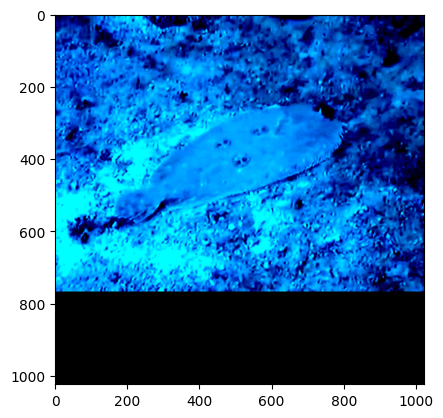

In [139]:
plt.imshow(x['image'][0].permute(1,2,0).numpy())
# plt.imshow(x['prev_masks'][0][0].permute(1,2,0).numpy()), x['name'][0]

In [140]:
import torch
pixel_mean = torch.Tensor([123.675, 116.28, 103.53]).view(-1, 1, 1)
pixel_std = torch.Tensor([58.395, 57.12, 57.375]).view(-1, 1, 1)

In [141]:
from pytorch_wavelets import DWTForward

dwt = DWTForward(J=1, wave = 'haar',mode='zero')

In [142]:
img = x['image'][0].unsqueeze(0) * pixel_std + pixel_mean
print(img.shape)
yl, yh = dwt(img)

torch.Size([1, 3, 1024, 1024])


In [143]:
yh[0].shape, yl.shape

(torch.Size([1, 3, 3, 512, 512]), torch.Size([1, 3, 512, 512]))

In [144]:
yl[0].permute(1,2,0).numpy() 

array([[[  0.       , 193.99998  , 226.       ],
        [  0.       , 193.99998  , 226.       ],
        [  0.       , 193.99998  , 226.       ],
        ...,
        [ 23.999998 , 229.99998  , 245.       ],
        [ 22.       , 229.99998  , 247.99998  ],
        [ 23.999998 , 231.99998  , 249.99998  ]],

       [[  0.       , 193.99998  , 226.       ],
        [  0.       , 193.99998  , 226.       ],
        [  0.       , 193.99998  , 226.       ],
        ...,
        [ 22.       , 227.99998  , 243.       ],
        [ 23.999998 , 229.99998  , 247.99998  ],
        [ 23.999998 , 231.99998  , 249.99998  ]],

       [[  1.9999846, 195.99998  , 227.99998  ],
        [  1.9999846, 195.99998  , 227.99998  ],
        [  1.9999846, 195.99998  , 227.99998  ],
        ...,
        [ 22.       , 227.99998  , 243.       ],
        [ 23.999998 , 229.99998  , 247.99998  ],
        [ 25.999998 , 231.99998  , 249.99998  ]],

       ...,

       [[247.34999  , 232.55998  , 207.06     ],
        [24

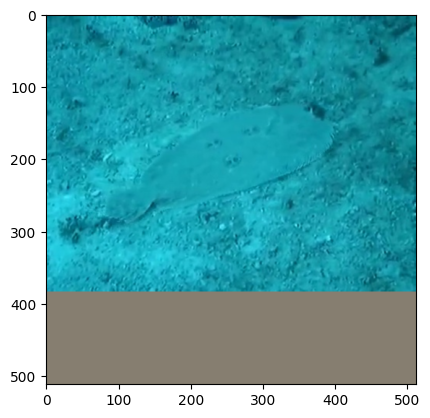

In [145]:
po = yl[0].permute(1,2,0).numpy()
po = (po - po.min()) / (po.max() - po.min())
plt.imshow(po)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


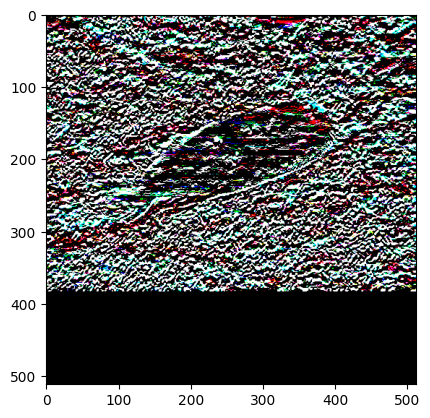

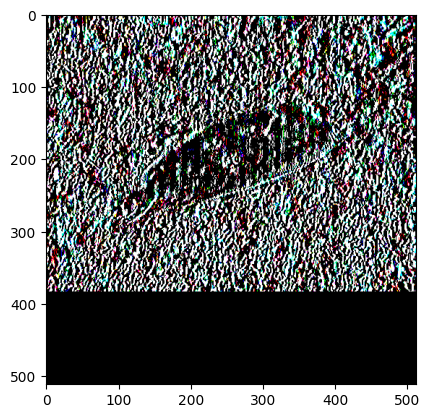

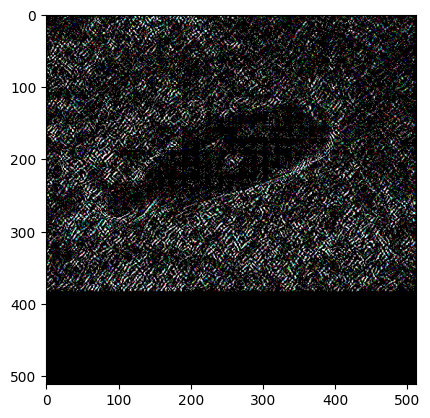

In [147]:
for i in range(3):
    plt.figure()
    po = yh[0][:,:,i,:,:][0].permute(1,2,0)
    # po = (po - po.min()) / (po.max() - po.min())
    plt.imshow(po)

In [3]:
for i in x:
    try:
        print(i, x[i].shape)
    except:
        pass


image torch.Size([1, 3, 3, 576, 1024])
gt_mask torch.Size([1, 1, 1, 1080, 1920])
prev_masks torch.Size([1, 1, 2, 256, 256])
selector torch.Size([1, 1])


In [3]:
x = next(iter(train_dataloader))
x['gt_mask'].unique()

/home/frozenwolf/miniconda3/envs/sam/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/frozenwolf/miniconda3/envs/sam/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None t

tensor([0., 1.])

In [4]:
# torch.Size([2, 1, 720, 1280])

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: frozenwolf (spider-r-d). Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/frozenwolf/miniconda3/envs/sam/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/frozenwolf/miniconda3/envs/sam/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly reco

Validation: 0it [00:00, ?it/s]

/home/frozenwolf/miniconda3/envs/sam/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/frozenwolf/miniconda3/envs/sam/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None t

torch.Size([1, 1, 720, 1280])
torch.Size([1, 720, 1280])
Imagelist


/home/frozenwolf/miniconda3/envs/sam/lib/python3.11/site-packages/lightning/pytorch/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


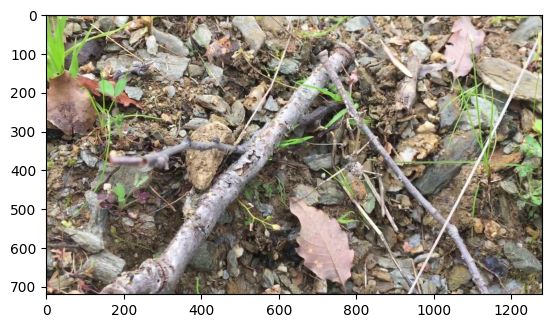

sep_mask_list_0


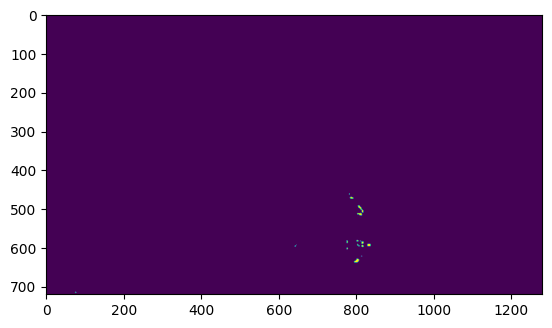

gt_mask_list_0


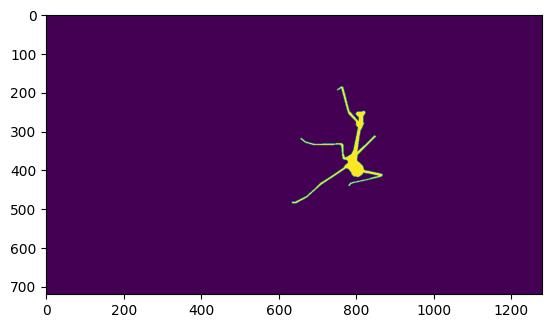

torch.Size([1, 1, 360, 540])
torch.Size([1, 360, 540])
Imagelist


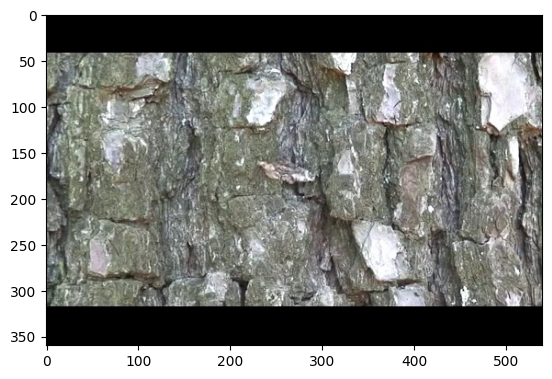

sep_mask_list_0


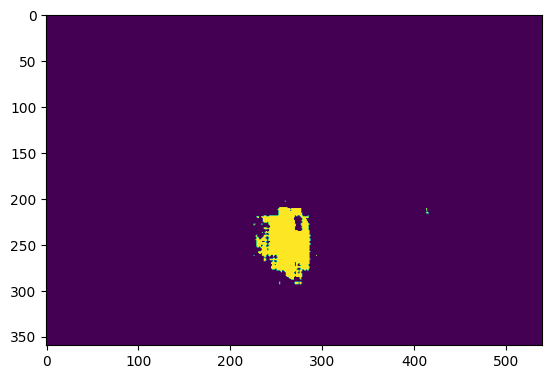

gt_mask_list_0


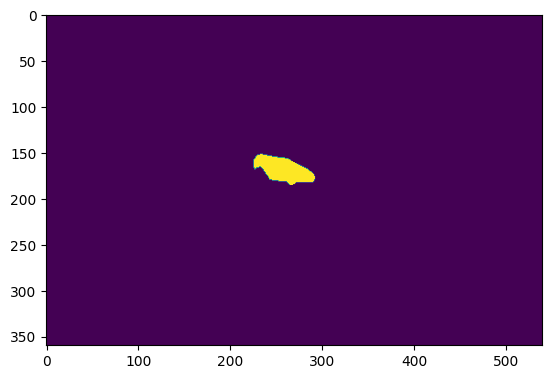

torch.Size([1, 1, 720, 1280])
torch.Size([1, 720, 1280])
Imagelist


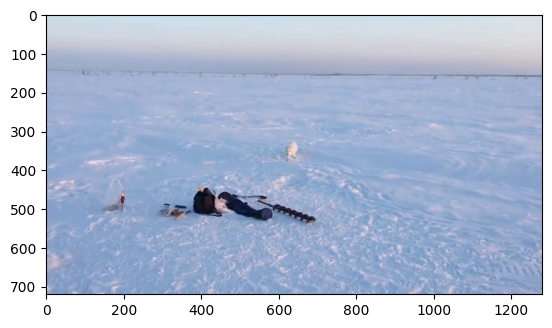

sep_mask_list_0


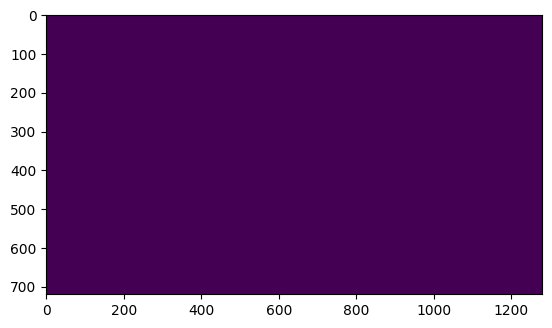

gt_mask_list_0


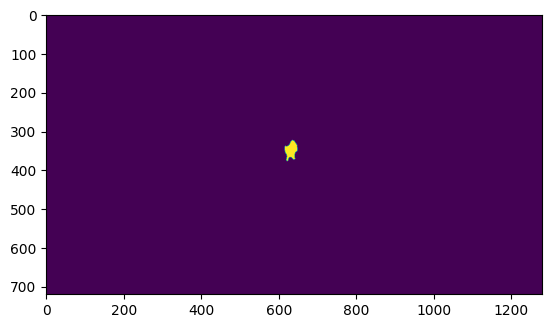

torch.Size([1, 1, 720, 1280])
torch.Size([1, 720, 1280])
Imagelist


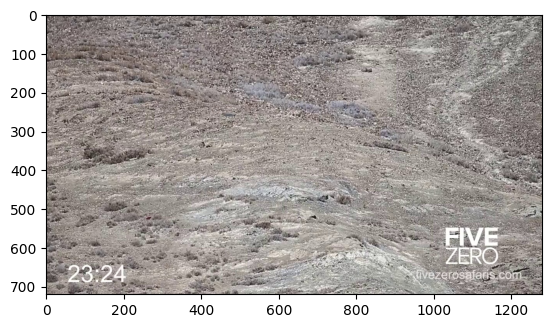

sep_mask_list_0


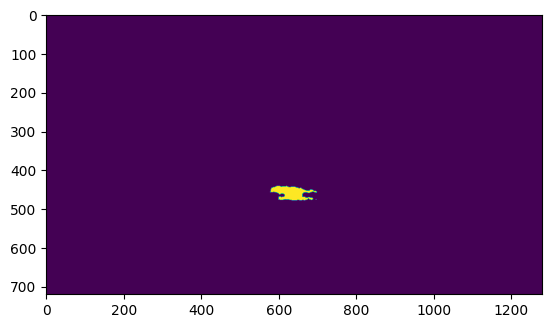

gt_mask_list_0


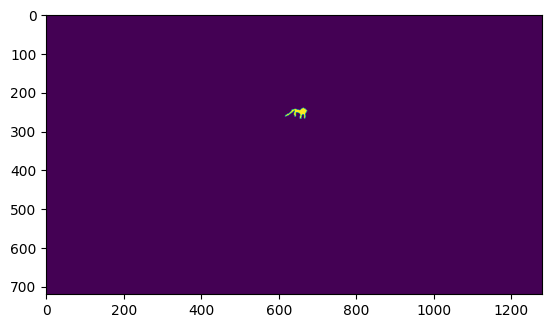

torch.Size([1, 1, 360, 540])
torch.Size([1, 360, 540])
Imagelist


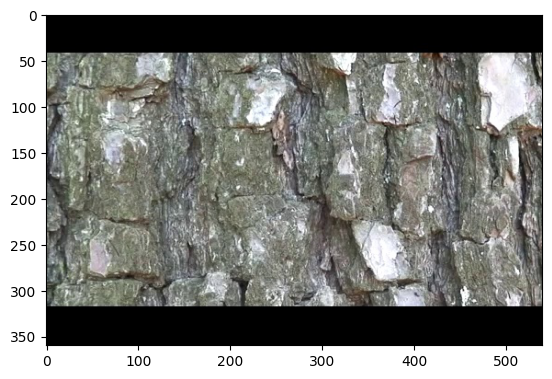

sep_mask_list_0


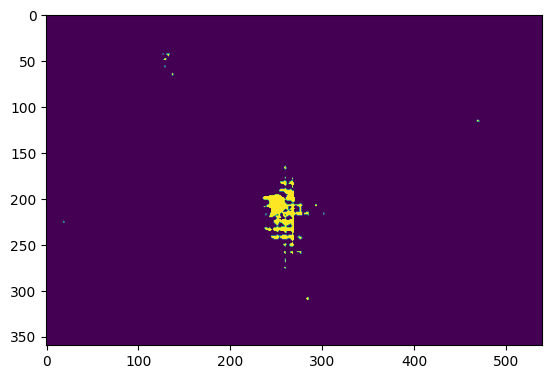

gt_mask_list_0


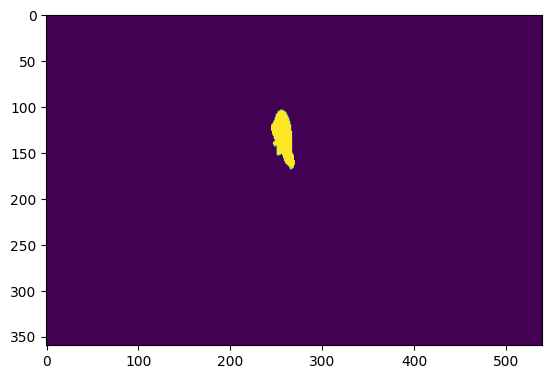

torch.Size([1, 1, 720, 1280])
torch.Size([1, 720, 1280])
Imagelist


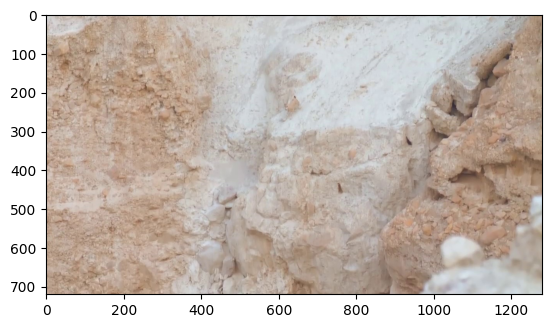

sep_mask_list_0


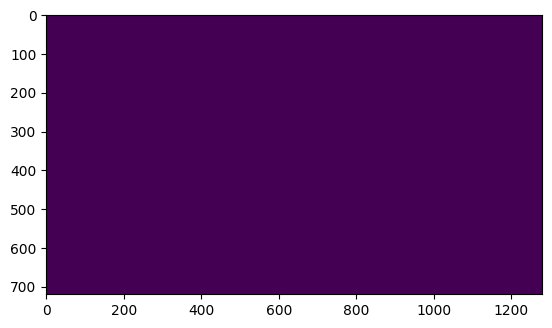

gt_mask_list_0


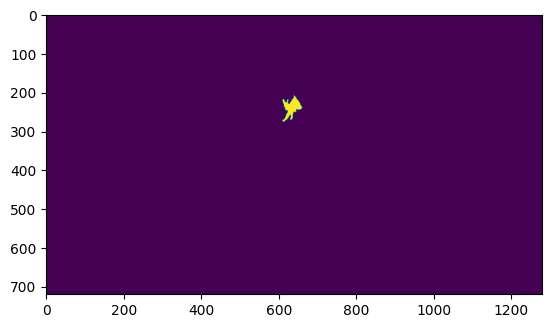

/home/frozenwolf/miniconda3/envs/sam/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [5]:
wandblogger = WandbLogger(project="DAVIS Propagation")

# wandblogger.experiment.config.update(config)
wandb.run.log_code(".")

trainer = L.Trainer(
    accelerator=device,
    devices=cfg.num_devices,
    precision=cfg.precision,
    # logger=wandblogger,
    max_epochs=cfg.num_epochs,
    # strategy="ddp",
    log_every_n_steps=15,
    check_val_every_n_epoch=20,
    enable_checkpointing=False,
    profiler='simple',
    # overfit_batches=1
)



trainer.validate(model, validation_dataloader)

In [ ]:
# torch.Size([2, 1, 720, 1280])
# torch.Size([1, 720, 1280])
# torch.Size([1, 720, 1280])



# torch.Size([2, 3, 1080, 1920])
# torch.Size([1, 1080, 1920])
# torch.Size([3, 1080, 1920])
# torch.Size([1, 1080, 1920])

In [ ]:
x = next(iter(train_dataloader))

/home/frozenwolf/miniconda3/envs/sam/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/frozenwolf/miniconda3/envs/sam/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None t

In [ ]:
x['gt_mask'].shape

torch.Size([1, 2, 1, 720, 1280])

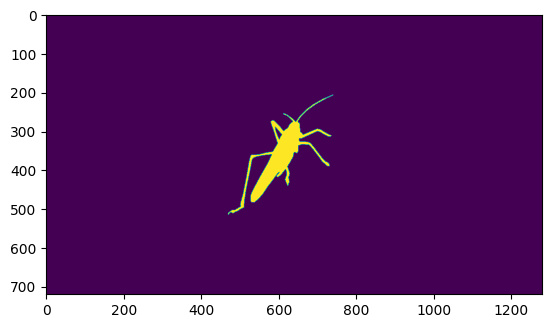

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(x['gt_mask'][0][0][0].numpy())

In [ ]:
x['image'].shape

torch.Size([1, 3, 3, 576, 1024])

In [ ]:
x['prev_masks'].shape

torch.Size([1, 1, 1, 256, 256])

In [ ]:
x['cropped_img'][0].shape, len(x['cropped_img'])

(torch.Size([1, 3, 720, 1280]), 2)

In [ ]:
x['selector']

tensor([[True]])

In [ ]:
train_dataloader.dataset.image_list[0]

['raw/MoCA-Mask/MoCA_Video/TrainDataset_per_sq/peacock_flounder_1/Imgs/00000.jpg',
 'raw/MoCA-Mask/MoCA_Video/TrainDataset_per_sq/peacock_flounder_1/Imgs/00005.jpg',
 'raw/MoCA-Mask/MoCA_Video/TrainDataset_per_sq/peacock_flounder_1/Imgs/00010.jpg']

In [ ]:
0/0

In [ ]:
x['gt_mask'].shape

torch.Size([1, 2, 3, 1080, 1920])

In [ ]:
x['image'].shape

torch.Size([1, 3, 3, 576, 1024])

In [ ]:
x['prev_masks'].shape

torch.Size([1, 1, 3, 256, 256])

In [ ]:
x['cropped_img'][0].shape, len(x['cropped_img'])

(torch.Size([1, 3, 1080, 1920]), 2)